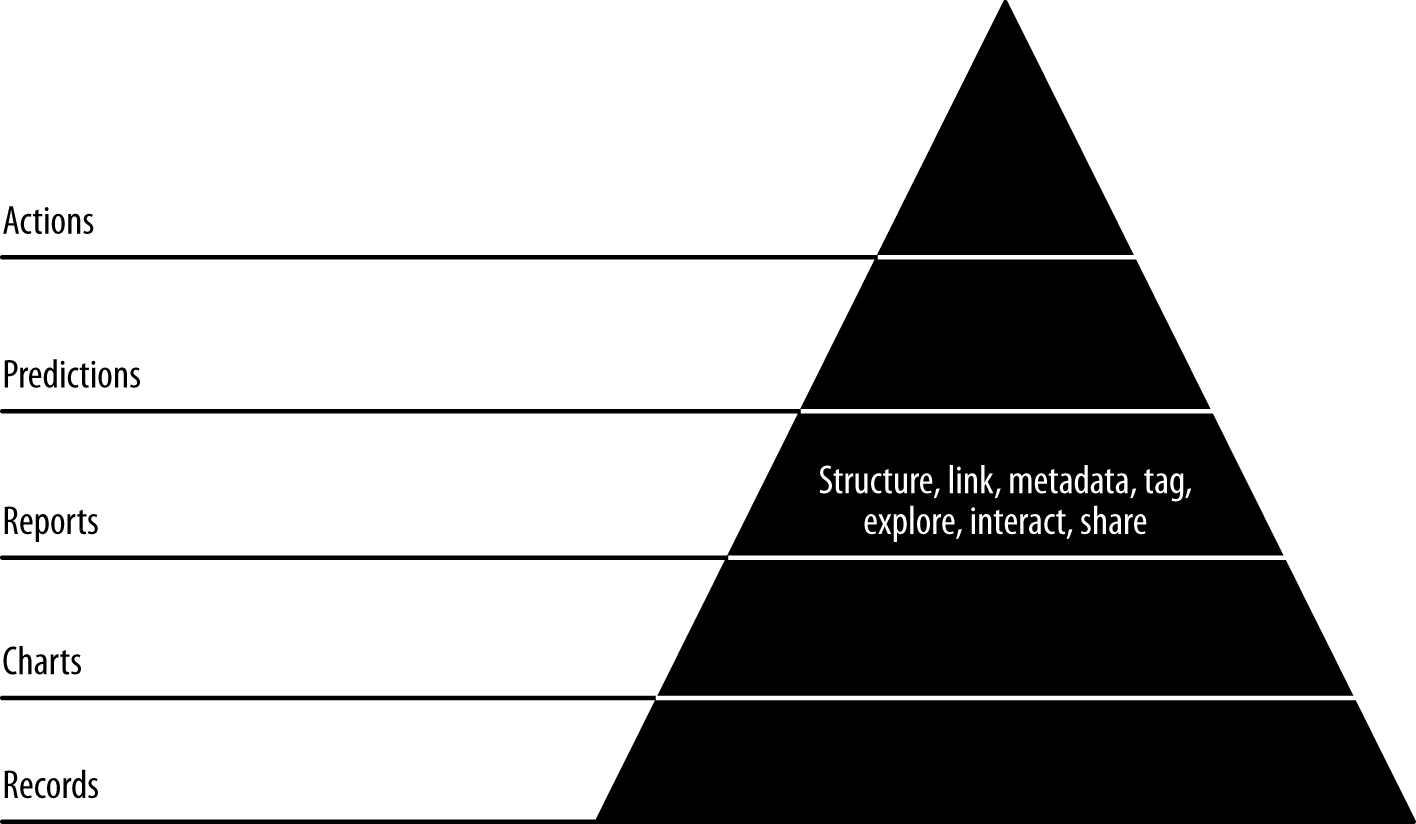

In the next step, our third agile sprint, we’ll extend our chart pages into full-blown reports. In this step, charts become interactive, static pages become dynamic, and our data becomes explorable through networks of linked, related entities with tables and charts. These are the characteristics of the reports stage of the data-value pyramid.

In [55]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


## Extracting Airlines (Entities)

To build a report, we need to compose multiple views of our dataset. Building these views corresponds with enumerating entities. The entity we created in the previous chapter, airplanes, will serve as a foundation as we increase the number of entities and the corresponding links between them to create reports. As with the last chapter, before we can start creating different views on our data, we need a web page to put our charts and tables into. So let’s create another entity, airlines, and give each a page of its own.

We start by gathering all tail numbers for a given airline in a table on its entity page. Every commercial flight has an airline it operates under, and each airline has a fleet of beautifully branded airplanes that, along with airport facilities and staff, are the key assets of its business. We already created a page for each airplane, so we’ll leverage this data asset to create a list of all tail numbers for each airline.

### Defining Airlines as Groups of Airplanes Using PySpark

We begin by preparing the lists of tail numbers for each airline code, in [ch06/extract_airlines.py](extract_airlines.py). These will form the basis for our airline pages:

In [3]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers foreach airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_airplane = spark.sql(
  "SELECT DISTINCT Carrier, TailNum FROM on_time_performance"
)
carrier_airplane.show(5)

+-------+-------+
|Carrier|TailNum|
+-------+-------+
|     AS| N581AS|
|     AS| N767AS|
|     DL| N333NW|
|     DL| N549US|
|     MQ| N847MQ|
+-------+-------+
only showing top 5 rows



In [4]:
# Now we need to store a sorted list of tail numbers for each carrier, along with a fleet count
tuple_pair = carrier_airplane.rdd.map(
    lambda nameTuple: (nameTuple[0], [nameTuple[1]])
)
tuple_pair.first()

('AS', ['N581AS'])

In [5]:
reduced_pairs = tuple_pair.reduceByKey(lambda a, b: a + b)
reduced_pairs.first()

('WN',
 ['N360SW',
  'N7732A',
  'N413WN',
  'N913WN',
  'N558WN',
  'N237WN',
  'N346SW',
  'N739GB',
  'N927WN',
  'N212WN',
  'N947WN',
  'N7822A',
  'N247WN',
  'N967WN',
  'N275WN',
  'N654SW',
  'N8649A',
  'N428WN',
  'N780SW',
  'N8603F',
  'N8646B',
  'N260WN',
  'N766SW',
  'N788SA',
  'N936WN',
  'N258WN',
  'N491WN',
  'N717SA',
  'N280WN',
  'N451WN',
  'N527SW',
  'N795SW',
  'N8308K',
  'N959WN',
  'N8606C',
  'N207WN',
  'N379SW',
  'N697SW',
  'N723SW',
  'N941WN',
  'N669SW',
  'N607SW',
  'N498WN',
  'N8634A',
  'N496WN',
  'N792SW',
  'N906WN',
  'N567WN',
  'N8307K',
  'N8328A',
  'N8624J',
  'N944WN',
  'N7719A',
  'N737JW',
  'N740SW',
  'N552WN',
  'N647SW',
  'N7844A',
  'N248WN',
  'N796SW',
  'N411WN',
  'N484WN',
  'N288WN',
  'N408WN',
  'N478WN',
  'N725SW',
  'N8648A',
  'N285WN',
  'N488WN',
  'N528SW',
  'N631SW',
  'N738CB',
  'N7815L',
  'N205WN',
  'N224WN',
  'N8313F',
  'N616SW',
  'N942WN',
  'N732SW',
  'N767SW',
  'N8303R',
  'N8656B',
  'N568WN

In [6]:
final_records = reduced_pairs.map(lambda tuple:
      {
        'Carrier': tuple[0], 
        'TailNumbers': sorted(
          filter(
            lambda x: x is not None and x != '', tuple[1] # empty string tail numbers were 
                                        # getting through
            )
          ),
        'FleetCount': len(tuple[1])
      }
    )
final_records.first()

{'Carrier': 'WN',
 'TailNumbers': ['7819A',
  '7820L',
  'N200WN',
  'N201LV',
  'N202WN',
  'N203WN',
  'N204WN',
  'N205WN',
  'N206WN',
  'N207WN',
  'N208WN',
  'N209WN',
  'N210WN',
  'N211WN',
  'N212WN',
  'N213WN',
  'N214WN',
  'N215WN',
  'N216WR',
  'N217JC',
  'N218WN',
  'N219WN',
  'N220WN',
  'N221WN',
  'N222WN',
  'N223WN',
  'N224WN',
  'N225WN',
  'N226WN',
  'N227WN',
  'N228WN',
  'N229WN',
  'N230WN',
  'N231WN',
  'N232WN',
  'N233LV',
  'N234WN',
  'N235WN',
  'N236WN',
  'N237WN',
  'N238WN',
  'N239WN',
  'N240WN',
  'N241WN',
  'N242WN',
  'N243WN',
  'N244WN',
  'N245WN',
  'N246LV',
  'N247WN',
  'N248WN',
  'N249WN',
  'N250WN',
  'N251WN',
  'N252WN',
  'N253WN',
  'N254WN',
  'N255WN',
  'N256WN',
  'N257WN',
  'N258WN',
  'N259WN',
  'N260WN',
  'N261WN',
  'N262WN',
  'N263WN',
  'N264LV',
  'N265WN',
  'N266WN',
  'N267WN',
  'N268WN',
  'N269WN',
  'N270WN',
  'N271LV',
  'N272WN',
  'N273WN',
  'N274WN',
  'N275WN',
  'N276WN',
  'N277WN',
  'N278WN

In [7]:
# Determine the total number of airlines in the dataset
total_airlines = final_records.count()
print("Total airlines making up US fleet: {}".format(total_airlines))

Total airlines making up US fleet: 14


#### Storing to MongoDB

Next we'll store this data in the `airplanes_per_carrier` collection.

In [ ]:
# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
final_records.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplanes_per_carrier'
)

print("Records stored to MongoDB!")

#### Verifying Records in MongoDB

In [8]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.count()'
mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.findOne()'

14
{
	"_id" : ObjectId("5aea6c9c2a35e7454fb4aa97"),
	"TailNumbers" : [
		"7819A",
		"7820L",
		"N200WN",
		"N201LV",
		"N202WN",
		"N203WN",
		"N204WN",
		"N205WN",
		"N206WN",
		"N207WN",
		"N208WN",
		"N209WN",
		"N210WN",
		"N211WN",
		"N212WN",
		"N213WN",
		"N214WN",
		"N215WN",
		"N216WR",
		"N217JC",
		"N218WN",
		"N219WN",
		"N220WN",
		"N221WN",
		"N222WN",
		"N223WN",
		"N224WN",
		"N225WN",
		"N226WN",
		"N227WN",
		"N228WN",
		"N229WN",
		"N230WN",
		"N231WN",
		"N232WN",
		"N233LV",
		"N234WN",
		"N235WN",
		"N236WN",
		"N237WN",
		"N238WN",
		"N239WN",
		"N240WN",
		"N241WN",
		"N242WN",
		"N243WN",
		"N244WN",
		"N245WN",
		"N246LV",
		"N247WN",
		"N248WN",
		"N249WN",
		"N250WN",
		"N251WN",
		"N252WN",
		"N253WN",
		"N254WN",
		"N255WN",
		"N256WN",
		"N257WN",
		"N258WN",
		"N259WN",
		"N260WN",
		"N261WN",
		"N262WN",
		"N263WN",
		"N264LV",
		"N265WN",
		"N266WN",
		"N267WN",
		"N268WN",
		"N269WN",
		"N270WN",
		"N271LV",
		"N272WN",
		"N273WN",
		"N274WN",
		"N275

### Building an Airline Page in Flask

Next we’ll create a controller for our airline page. Check out [ch06/web/report_flask.py](web/report_flask.py).

#### Airline Page Controller

Our Flask controller is simple. It accepts an airline carrier code and returns a page with a list of airplanes, by tail number, from Mongo:

```python
# Controller: Fetch an airplane entity page
@app.route("/airlines/<carrier_code>")
def airline(carrier_code):
  airline_airplanes = client.agile_data_science.airplanes_per_carrier.find_one(
    {'Carrier': carrier_code}
  )
  return render_template(
    'airlines.html',
    airline_airplanes=airline_airplanes,
    carrier_code=carrier_code
  )
```

#### Airline Page Template

Our template code creates an HTML bullet for each tail number. Check out [ch06/web/templates/airlines.html](web/templates/airlines.html):

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a> / <a href="/airlines/{{carrier_code}}">{{carrier_code}}</a>

  <!-- Summary -->
  <p style="text-align: justify;">{{airline_summary.summary}}</p>
  <h4>Fleet: {{airline_airplanes.FleetCount}} Planes</h4>
  <ul class="nav nav-pills">
    {% for tail_number in airline_airplanes.TailNumbers -%}
    <li class="button">
      <a href="/airplanes/{{tail_number}}">{{tail_number}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

Now in a terminal, change directory to `ch06/web` and run the file `report_flask.py`:

```bash
cd ch06/web
python ./report_flask.py
```

#### Airline Page Result

Now you can visit the resulting web page at [http://localhost:5000/airlines2/DL](http://localhost:5000/airlines2/DL):

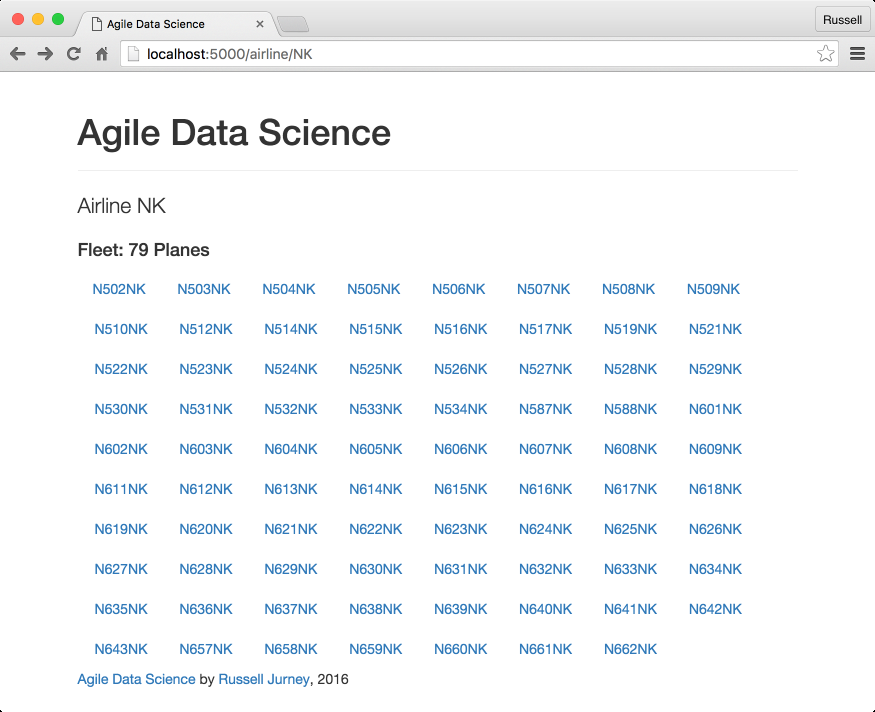

The result is the start of an airline page detailing its entire fleet. Don’t worry, we’ll dress this up later. It is absolutely necessary to ship something ugly before you ship something sharp!

### Linking Back to Our Airline Page

Having created the airline entity page type, we will now link back to it from the airplane page we created, and the search and flight pages in from Chapter 5. We do this by editing the templates for the airplane, flight, and search pages.

We edit [ch06/web/templates/flights_per_airplane.html](web/templates/flights_per_airplane.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights['Flights'] %}
        <tr>
          <td><a href="/airlines/{{flight['Carrier']}}">{{flight['Carrier']}}</a></td>
          <td>{{flight['FlightDate']}}</td>
          <td><a href="/on_time_performance?Carrier={{flight['Carrier']}}&FlightDate={{flight['FlightDate']}}&FlightNum={{flight['FlightNum']}}">{{flight['FlightNum']}}</a></td>
          <td>{{flight['Origin']}}</td>
          <td>{{flight['Dest']}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/airplane/flights/N35236](http://localhost:5000/airplane/flights/N35236):

We edit [ch06/web/templates/flight.html](web/templates/flight.html):

```html
    <table class="table">
      <thead>
        <th>Airline</th>
        <th>Origin</th>
        <th>Destination</th>
        <th>Tail Number</th>
        <th>Date</th>
        <th>Air Time</th>
        <th>Distance</th>
      </thead>
      <tbody>
        <tr>
          <td><a href="/airlines/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td><a href="/airplane/flights/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-01&FlightNum=478](http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-01&FlightNum=478):

And finally we edit [ch06/web/templates/search.html](web/templates/search.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights %}
        <tr>
          <td><a href="/airlines/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td><a href="/on_time_performance?Carrier={{flight.Carrier}}&FlightDate={{flight.FlightDate}}&FlightNum={{flight.FlightNum}}">{{flight.FlightNum}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.DepTime}}</td>
          <td><a href="/airplane/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/flights/search](http://localhost:5000/flights/search)

## Creating an All Airlines Home Page

But who knows airline carrier codes (okay, other than me)? We need a way to get users started browsing, so let’s create a home page listing all the airlines operating in the US.

Our controller is simple, just six lines of code. We’re able to reuse the airlines_per_carrier MongoDB collection, this time ignoring the tail numbers and only querying the carrier codes using a find. Let’s also direct users to this page by default, as our index.html for this application:

```python
# Controller: Fetch an airplane entity page
@app.route("/")
@app.route("/airlines")
@app.route("/airlines/")
def airlines():
  airlines = client.agile_data_science.airplanes_per_carrier.find()
  return render_template('all_airlines.html', airlines=airlines)
```

Our template is similar to the one for an individual airline:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a>

  <p class="lead">US Domestic Airlines</p>
  <ul class="nav nav-pills">
    {% for airline in airlines -%}
    <li class="button">
      <a href="/airlines/{{airline.Carrier}}">{{airline.Carrier}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

The result is a simple but effective way to get users browsing the world of aviation. Check out [http://localhost:5000/](http://localhost:5000):

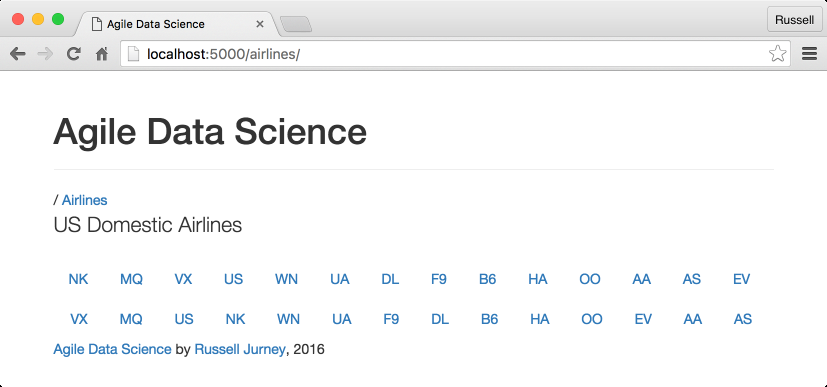



## Curating Ontologies of Semi-structured Data

We can now explore airlines, airplanes, and flights endlessly! Big deal, right? Maybe not, but it is a good start. Let’s extend this by making airplanes and airlines clickable in our flight pages.

Now we can look at airplanes and airlines, their properties, and their relationships as we view flights. This kind of pivot offers insight, and is a form of simple recommendation.

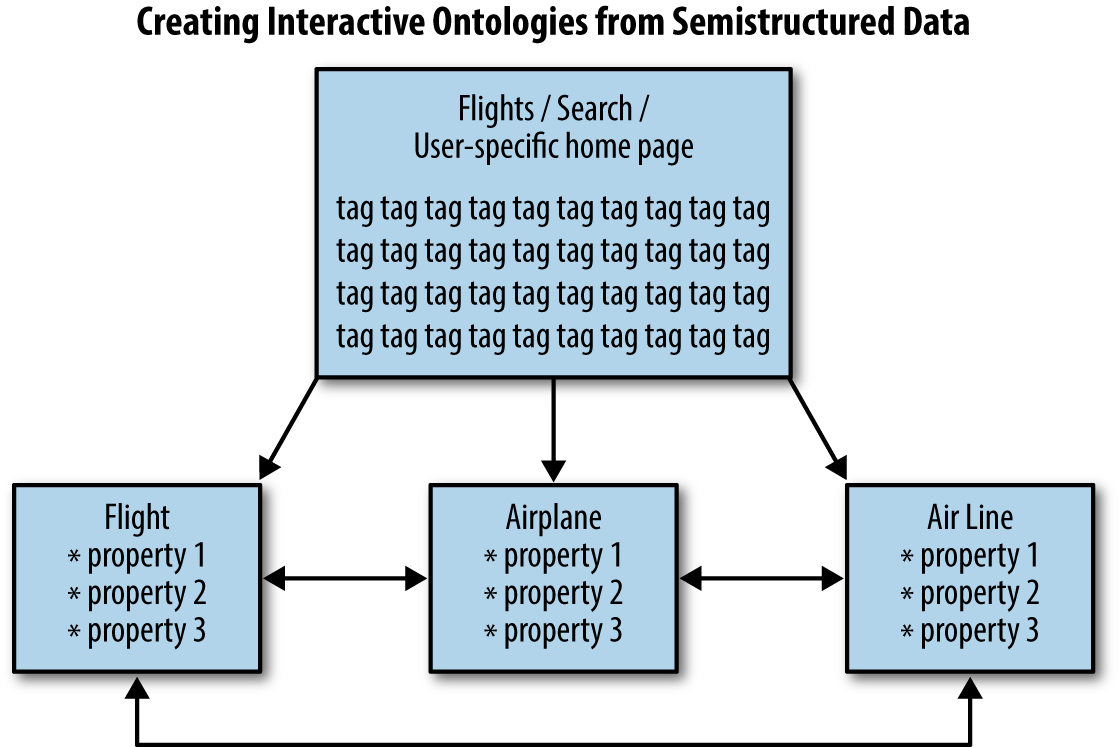

What we’re doing can be described as creating interactive ontologies of semi-structured data. Breaking up our process around building this kind of structure does several things for us. First, it creates small batches of work—one per entity—that break efficiently into agile sprints. This enables a kind of data agility, and also extends our application into a more and more browsable state. This in turn enables users to click around and explore our dataset, which connects the team into the ground truth or reality of the data—which, as you know by now, is a theme in Agile Data Science.

## Improving Airlines

Now that we’ve got airline pages, let’s improve them with some multimedia content: text and images. To begin, let’s get a list of the carrier codes in our primary dataset:

In [9]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers 
# for each airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_codes = spark.sql(
  "SELECT DISTINCT Carrier FROM on_time_performance"
)
carrier_codes.collect()

[Row(Carrier='UA'),
 Row(Carrier='NK'),
 Row(Carrier='AA'),
 Row(Carrier='EV'),
 Row(Carrier='B6'),
 Row(Carrier='DL'),
 Row(Carrier='OO'),
 Row(Carrier='F9'),
 Row(Carrier='US'),
 Row(Carrier='MQ'),
 Row(Carrier='HA'),
 Row(Carrier='AS'),
 Row(Carrier='VX'),
 Row(Carrier='WN')]

### Adding Names to Carrier Codes

In order to link more data to our carriers, we need to get the name of each along with the carrier code. This data is available in the airlines database we downloaded from OpenFlights in Chapter 5. Let’s inspect airlines.dat, which we’ve renamed airlines.csv:

In [10]:
%%bash

cat ../data/airlines.csv | grep '"DL"\|"NW"\|"AA"'

24,"American Airlines",\N,"AA","AAL","AMERICAN","United States","Y"
2009,"Delta Air Lines",\N,"DL","DAL","DELTA","United States","Y"
3731,"Northwest Airlines",\N,"NW","NWA","NORTHWEST","United States","Y"


#### Loading OpenFlights in PySpark

OpenFlights lists the fieldnames as Airline ID, Name, Alias, 2-Letter IATA Code, 3-Letter ICAO Code, Callsign, Country, and Active. Let’s open and inspect this data in PySpark. 

Check out [ch06/add_name_to_airlines.py](add_name_to_airlines.py):

In [17]:
airlines = spark.read.format('com.databricks.spark.csv')\
  .options(
      header='false', 
      nullValue='\\N'
  )\
  .load('../data/airlines.csv')
airlines.show(5)

+---+--------------------+----+----+---+-------+--------------+---+
|_c0|                 _c1| _c2| _c3|_c4|    _c5|           _c6|_c7|
+---+--------------------+----+----+---+-------+--------------+---+
| -1|             Unknown|null|   -|N/A|   null|          null|  Y|
|  1|      Private flight|null|   -|N/A|   null|          null|  Y|
|  2|         135 Airways|null|null|GNL|GENERAL| United States|  N|
|  3|       1Time Airline|null|  1T|RNX|NEXTIME|  South Africa|  Y|
|  4|2 Sqn No 1 Elemen...|null|null|WYT|   null|United Kingdom|  N|
+---+--------------------+----+----+---+-------+--------------+---+
only showing top 5 rows



Lets check if Delta Airlines is in the data, carrier code `DL`.

In [18]:
# Is Delta around?
airlines.filter(airlines._c3 == 'DL').show()

+----+---------------+----+---+---+-----+-------------+---+
| _c0|            _c1| _c2|_c3|_c4|  _c5|          _c6|_c7|
+----+---------------+----+---+---+-----+-------------+---+
|2009|Delta Air Lines|null| DL|DAL|DELTA|United States|  Y|
+----+---------------+----+---+---+-----+-------------+---+



#### Joining FAA Carrier Codes to OpenFlights Carrier Records

Now let’s filter this data down to just the airline names and two-letter carrier codes, and join it to the unique carrier codes from the on-time performance dataset. As we did last chapter, we'll repartition the data to a single partition to get a single JSON file.

In [19]:
# Drop fields except for C1 as name, C3 as carrier code
airlines.registerTempTable("airlines")
airlines = spark.sql("SELECT _c1 AS Name, _c3 AS CarrierCode from airlines")

# Check out the OpenFlights airlines record for Delta
airlines.filter(airlines.CarrierCode == 'DL').show()

# Check out the FAA codes record for Delta
carrier_codes.filter(carrier_codes.Carrier == 'DL').show()

# Join our 14 carrier codes to the airlines table to get our set of airlines
our_airlines = carrier_codes.join( 
  airlines, carrier_codes.Carrier == airlines.CarrierCode
)
our_airlines = our_airlines.select('Name', 'CarrierCode')
our_airlines.show()

our_airlines.repartition(1).write.mode('overwrite').json("../data/our_airlines.json")

+---------------+-----------+
|           Name|CarrierCode|
+---------------+-----------+
|Delta Air Lines|         DL|
+---------------+-----------+

+-------+
|Carrier|
+-------+
|     DL|
+-------+

+--------------------+-----------+
|                Name|CarrierCode|
+--------------------+-----------+
|     United Airlines|         UA|
|     Spirit Airlines|         NK|
|   American Airlines|         AA|
|Atlantic Southeas...|         EV|
|     JetBlue Airways|         B6|
|     Delta Air Lines|         DL|
|             SkyWest|         OO|
|   Frontier Airlines|         F9|
|          US Airways|         US|
|American Eagle Ai...|         MQ|
|   Hawaiian Airlines|         HA|
|     Alaska Airlines|         AS|
|      Virgin America|         VX|
|  Southwest Airlines|         WN|
+--------------------+-----------+



#### Verifying Our Result

Now lets create a single JSON Lines file from the single partition JSON file and then check our result:

In [20]:
%%bash

cat ../data/our_airlines.json/part*.json >> ../data/our_airlines.jsonl
head -5 ../data/our_airlines.jsonl

{"Name":"United Airlines","CarrierCode":"UA"}
{"Name":"Spirit Airlines","CarrierCode":"NK"}
{"Name":"American Airlines","CarrierCode":"AA"}
{"Name":"Atlantic Southeast Airlines","CarrierCode":"EV"}
{"Name":"JetBlue Airways","CarrierCode":"B6"}


### Incorporating Wikipedia Content

Now that we have airline names, we can use Wikipedia to get various information about each airline, like a summary, logo, and company website! To do so, we make use of the wikipedia package for Python, which wraps the MediaWiki API. We’ll be using `BeautifulSoup` again to parse the page’s HTML.

Check out [ch06/enrich_airlines_wikipedia.py](enrich_airlines_wikipedia.py):

In [23]:
import sys, os, re
sys.path.append("lib")
import utils

import wikipedia
from bs4 import BeautifulSoup
import tldextract

# Load our airlines...
our_airlines = utils.read_json_lines_file('../data/our_airlines.jsonl')

# Build a new list that includes Wikipedia data
with_url = []
for airline in our_airlines:
  
  # Get the Wikipedia page for the airline name
  wikipage = wikipedia.page(airline['Name'])

  # Get the summary
  summary = wikipage.summary
  airline['summary'] = summary

  # Get the HTML of the page
  page = BeautifulSoup(wikipage.html(), "lxml")

  # Task: get the logo from the right 'vcard' column
  # 1) Get the vcard table
  vcard_table = page.find_all('table', class_='vcard')[0]
  # 2) The logo is always the first image inside this table
  first_image = vcard_table.find_all('img')[0]
  # 3) Set the URL to the image
  logo_url = 'http:' + first_image.get('src')
  airline['logo_url'] = logo_url

  # Task: get the company website
  # 1) Find the 'Website' table header
  th = page.find_all('th', text='Website')[0]
  # 2) Find the parent tr element
  tr = th.parent
  # 3) Find the a (link) tag within the tr
  a = tr.find_all('a')[0]
  # 4) Finally, get the href of the a tag
  url = a.get('href')
  airline['url'] = url

  # Get the domain to display with the URL
  url_parts = tldextract.extract(url)
  airline['domain'] = url_parts.domain + '.' + url_parts.suffix

  print(airline)
  with_url.append(airline)

utils.write_json_lines_file(with_url, '../data/our_airlines_with_wiki.jsonl')

{'Name': 'United Airlines', 'CarrierCode': 'UA', 'summary': "United Airlines, Inc., commonly referred to as United, is a major U.S. airline headquartered in Chicago, Illinois. It is the world's third-largest airline when measured by revenue, after American Airlines and Delta Air Lines. United operates a large domestic and international route network, with an extensive presence in the Asia-Pacific region. United is a founding member of the Star Alliance, the world's largest airline alliance with a total of 28 member airlines. Regional service is operated by independent carriers under the brand name United Express. Its main competitors are American Airlines, Delta Air Lines, Alaska Airlines, and Southwest Airlines.\nUnited was established by the amalgamation of several airlines in the late 1920s, the oldest of these being Varney Air Lines, which was founded in 1926.\nUnited has nine hubs, with Chicago—O'Hare being its largest in terms of both passengers carried (16.8 million in 2016) and

{'Name': 'Frontier Airlines', 'CarrierCode': 'F9', 'summary': 'Frontier Airlines is an American ultra low cost carrier headquartered in Denver, Colorado. The 8th largest commercial airline in the US, Frontier Airlines operates flights to over 80 destinations throughout the United States and 6 international destinations, with ambitious expansion plans. The carrier is a subsidiary and operating brand of Indigo Partners, LLC, and maintains a hub at Denver International Airport with numerous focus cities across the United States. Also, under a codeshare agreement with Mexican ultra low cost carrier Volaris, to begin in Spring 2018, the airline will connect passengers throughout its network.', 'logo_url': 'http://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Frontier_airlines_logo14.png/250px-Frontier_airlines_logo14.png', 'url': 'http://www.flyfrontier.com/', 'domain': 'flyfrontier.com'}
{'Name': 'US Airways', 'CarrierCode': 'US', 'summary': 'US Airways (formerly known as USAir) was a 

{'Name': 'Virgin America', 'CarrierCode': 'VX', 'summary': 'Virgin America was an American airline that operated between 2007 and 2018; it was integrated into Alaska Airlines in 2018. The airline primarily focused on operating low-fare service between cities on the West Coast and other major metropolitan areas, with higher quality service.\nThe airline began operations in 2007 as an independent airline using branding licensed from the United Kingdom-based Virgin Group, which also controls the brand of the Virgin Atlantic and Virgin Australia airlines. The Alaska Air Group acquired Virgin America in April 2016, at a cost of approximately $4 billion and continued to operate Virgin America under its own name and brand until airline was fully merged into Alaska Airlines on April 24, 2018.\nIt was headquartered in the San Francisco Bay Area city of Burlingame, and operated domestic flights to major U.S. cities, primarily from hubs at San Francisco and Los Angeles as well as a smaller focus 

#### Verifying Our Result

Now check out our work:

In [25]:
%%bash

head -1 ../data/our_airlines_with_wiki.jsonl

{"Name": "United Airlines", "CarrierCode": "UA", "summary": "United Airlines, Inc., commonly referred to as United, is a major U.S. airline headquartered in Chicago, Illinois. It is the world's third-largest airline when measured by revenue, after American Airlines and Delta Air Lines. United operates a large domestic and international route network, with an extensive presence in the Asia-Pacific region. United is a founding member of the Star Alliance, the world's largest airline alliance with a total of 28 member airlines. Regional service is operated by independent carriers under the brand name United Express. Its main competitors are American Airlines, Delta Air Lines, Alaska Airlines, and Southwest Airlines.\nUnited was established by the amalgamation of several airlines in the late 1920s, the oldest of these being Varney Air Lines, which was founded in 1926.\nUnited has nine hubs, with Chicago—O'Hare being its largest in terms of both passengers carried (16.8 million in 2016) and

### Publishing Enriched Airlines to Mongo

Note that we skipped Mongo in this section—we went from our original dataset to two stages of enriched, intermediate datasets without storing to Mongo at all. This is fine! In Agile Data Science we use databases to publish data, not always to persist it in its intermediate state.

Now, however, we want to include our enriched airlines in the airline web pages we created earlier. To get it there, we need to send it through Mongo. Since we already have a JSON file prepared, we can use the mongoimport command to load it into Mongo:

In [26]:
%%bash

mongoimport -d agile_data_science -c airlines --file ../data/our_airlines_with_wiki.jsonl

2018-05-07T02:56:34.436+0000	connected to: localhost
2018-05-07T02:56:34.453+0000	imported 14 documents


#### Verifying Records in Mongo

Now lets check for a record:

In [27]:
%%bash

mongo agile_data_science --quiet --eval 'db.airlines.findOne()'

{
	"_id" : ObjectId("5aefc062c11f972f229bf487"),
	"Name" : "Spirit Airlines",
	"CarrierCode" : "NK",
	"summary" : "Spirit Airlines, Inc. (NYSE: SAVE) is an American ultra-low-cost carrier headquartered in Miramar, Florida. It is the 7th largest commercial airline in the US. Spirit operates scheduled flights throughout the United States and in the Caribbean, Mexico, Latin America, and South America. The airline operates bases at Atlantic City, Chicago–O'Hare, Dallas/Fort Worth, Detroit, Fort Lauderdale, and Las Vegas.",
	"logo_url" : "http://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Spirit_Airlines_logo_2014.svg/250px-Spirit_Airlines_logo_2014.svg.png",
	"url" : "http://www.spirit.com",
	"domain" : "spirit.com"
}


### Enriched Airlines on the Web

Now that our enriched airline records are in Mongo, we can alter our Flask controller for `/airlines` to include this data. Check out [ch06/web/report_flask.py](web/report_flask.py), where we've added the `airline_summary` data to a copy of the `airline` controller as `airline2`:

```python
# Controller: Fetch an airplane entity page
@app.route("/airlines2/<carrier_code>")
def airline2(carrier_code):
  airline_summary = client.agile_data_science.airlines.find_one(
    {'CarrierCode': carrier_code}
  )
  airline_airplanes = client.agile_data_science.airplanes_per_carrier.find_one(
    {'Carrier': carrier_code}
  )
  return render_template(
    'airlines2.html',
    airline_summary=airline_summary,
    airline_airplanes=airline_airplanes,
    carrier_code=carrier_code
  )
```

Next we alter our template, [ch06/web/templates/airlines2.html](web/templates/airlines2.html), to include the Wikipedia data:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a> / <a href="/airline/{{carrier_code}}">{{carrier_code}}</a>

  <!-- Logo -->
  <img src="{{airline_summary.logo_url}}" style="float: right;"/>

  <p class="lead">
    <!-- Airline Name and website-->
    {{airline_summary.Name}}
    / <a href="{{airline_summary.url}}">{{airline_summary.domain}}</a>
  </p>

  <!-- Summary -->
  <p style="text-align: justify;">{{airline_summary.summary}}</p>
  <h4>Fleet: {{airline_airplanes.FleetCount}} Planes</h4>
  <ul class="nav nav-pills">
    {% for tail_number in airline_airplanes.TailNumbers -%}
    <li class="button">
      <a href="/airplane/{{tail_number}}">{{tail_number}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

Now checkout [http://localhost:5000/airlines2/DL](http://localhost:5000/airlines2/DL): 

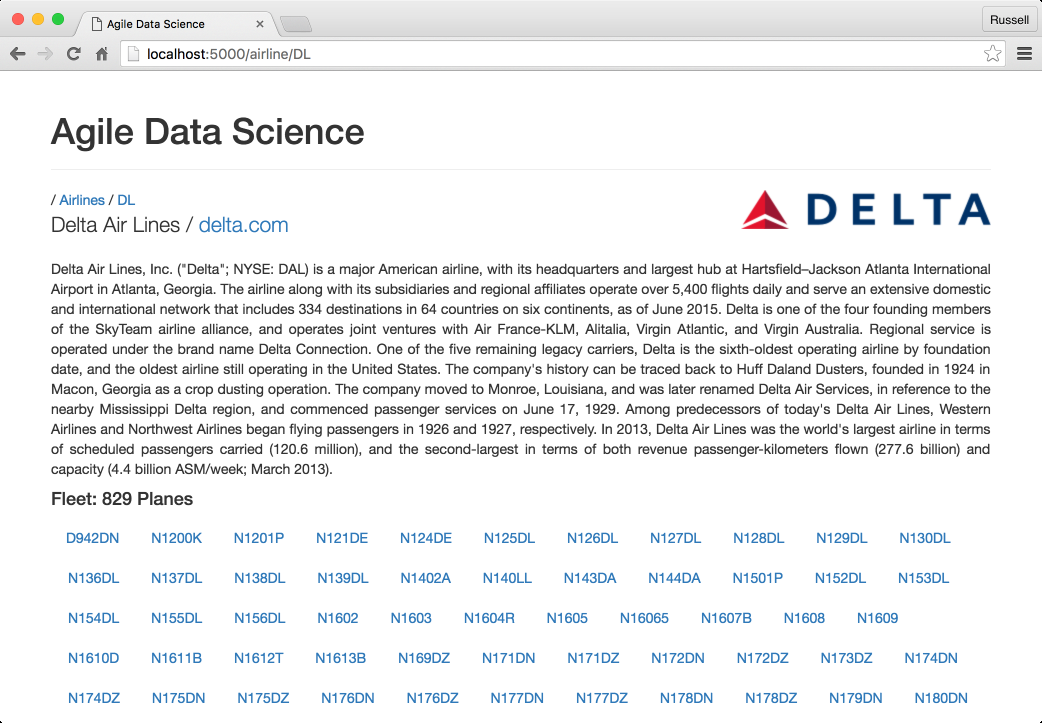

And for our labors, we get a greatly improved airline page. The point of this enrichment? While your data may not be so easily enhanced from a public dataset like Wikipedia, this example shows how to combine data from different sources, some private, some public, to compose better entity pages.

## Investigating Airplanes (Entities)

In Chapter 5, we were just getting into some interesting data that we will now look at once again. To begin, let’s store our enriched airplanes in their own intermediate dataset. Check out [ch06/prepare_airplanes.py](prepare_airlines.py):

In [31]:
# Load the FAA N-Number inquiry records
faa_tail_number_inquiry = spark.read.json('../data/faa_tail_number_inquiry.jsonl')
faa_tail_number_inquiry.show()

# Count the records
faa_tail_number_inquiry.count()

# Load our unique tail numbers
unique_tail_numbers = spark.read.json('../data/tail_numbers.jsonl')
unique_tail_numbers.show()

# Join tail numbers to our inquries
tail_num_plus_inquiry = unique_tail_numbers.join(
  faa_tail_number_inquiry,
  unique_tail_numbers.TailNum == faa_tail_number_inquiry.TailNum,
)
tail_num_plus_inquiry = tail_num_plus_inquiry.drop(unique_tail_numbers.TailNum)
tail_num_plus_inquiry.show()

# Dump extra field and store tail_numbers plus inquiry
tail_num_plus_inquiry.registerTempTable("tail_num_plus_inquiry")
airplanes = spark.sql("""SELECT
  TailNum AS TailNum,
  engine_manufacturer AS EngineManufacturer,
  engine_model AS EngineModel,
  manufacturer AS Manufacturer,
  mfr_year AS ManufacturerYear,
  model AS Model,
  owner AS Owner,
  owner_state AS OwnerState,
  serial_number AS SerialNumber
FROM
  tail_num_plus_inquiry""")

airplanes.repartition(1).write.mode('overwrite').json('../data/airplanes.json')

+-------+-------------------+------------+--------------------+--------+-----------+--------------------+-------------+-------------+
|TailNum|engine_manufacturer|engine_model|        manufacturer|mfr_year|      model|               owner|  owner_state|serial_number|
+-------+-------------------+------------+--------------------+--------+-----------+--------------------+-------------+-------------+
| N933EV|                 GE| CF34 SERIES|      BOMBARDIER INC|    2005|CL-600-2B19| DELTA AIR LINES INC|      GEORGIA|         8022|
| N917WN|           CFM INTL|  CFM56-7B24|              BOEING|    2008|    737-7H4|SOUTHWEST AIRLINE...|        TEXAS|        36624|
| N438WN|          CFM INTL.|CFM56 SERIES|              BOEING|    2003|    737-7H4|SOUTHWEST AIRLINE...|        TEXAS|        29833|
| N283VA|           CFM INTL| CFM56-5B4/3|              AIRBUS|    2015|   A320-214|  VIRGIN AMERICA INC|   CALIFORNIA|         6787|
| N473UA|           IVCHENKO| AL-25SERIES|    AIRBUS INDUSTRIE

As before, we can copy this directory of data into a single file for convenient access outside of Spark—note that this is not a good idea for very large files, but in this case our airplanes data is less than one megabyte:

In [32]:
%%bash

cat ../data/airplanes.json/part* >> ../data/airplanes.jsonl
head -5 ../data/airplanes.jsonl

{"TailNum":"N365AA","EngineManufacturer":"P&W CANADA","EngineModel":"PW206C","Manufacturer":"AGUSTA SPA","ManufacturerYear":"2001","Model":"A109E","Owner":"TRISTATE CARE FLIGHT LLC","OwnerState":"ARIZONA","SerialNumber":"11102"}
{"TailNum":"N424AA","EngineManufacturer":"P & W","EngineModel":"JT8D SERIES","Manufacturer":"MCDONNELL DOUGLAS","ManufacturerYear":"1986","Model":"DC-9-82(MD-82)","Owner":"AMERICAN AIRLINES INC","OwnerState":"TEXAS","SerialNumber":"49336"}
{"TailNum":"N426AA","EngineManufacturer":"P & W","EngineModel":"JT8D SERIES","Manufacturer":"MCDONNELL DOUGLAS","ManufacturerYear":"1986","Model":"DC-9-82(MD-82)","Owner":"AMERICAN AIRLINES INC","OwnerState":"TEXAS","SerialNumber":"49338"}
{"TailNum":"N434AA","EngineManufacturer":"P & W","EngineModel":"JT8D SERIES","Manufacturer":"MCDONNELL DOUGLAS","ManufacturerYear":"1987","Model":"DC-9-83(MD-83)","Owner":"AMERICAN AIRLINES INC","OwnerState":"TEXAS","SerialNumber":"49452"}
{"TailNum":"N437AA","EngineManufacturer":"P & W","E

# Boeing Versus Airbus

Let’s begin our analysis by asking a question: Boeing versus Airbus—who manufactures more airplanes in the US commercial fleet? 

Note that we ORDER BY both the Total and the Manufacturer. Always employ an additional “tiebreaker” sort key like this, so that your results are repeatable. Without a second sort key, the order of the results is not specified by the query and is at the mercy of the SQL interpreter.

Check out [ch06/analyze_airplanes.py](analyze_airplanes.py):

In [56]:
airplanes = spark.read.json('data/airplanes.json')
airplanes.registerTempTable("airplanes")

manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  COUNT(*) AS Total
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC"""
)
manufacturer_counts.show(10) # show top 30

+--------------------+-----+
|        Manufacturer|Total|
+--------------------+-----+
|              BOEING| 7812|
|              AIRBUS| 2076|
|      BOMBARDIER INC| 1712|
|    AIRBUS INDUSTRIE| 1704|
|             EMBRAER| 1320|
|   MCDONNELL DOUGLAS|  464|
|MCDONNELL DOUGLAS...|  412|
|         EMBRAER S A|  172|
|MCDONNELL DOUGLAS...|   56|
|              CESSNA|   36|
+--------------------+-----+
only showing top 10 rows



Interesting, Boeing planes outnumber Airbus planes by 4 to 1! I had no idea; I thought it was much closer than this. However, what I really want to know is who has what share of the market (without having to compute a ratio in my head). In other words, I’d like to see this data as a percentage.

## SQL Subqueries Versus Dataflow Programming

This is a good way to illustrate the difference between SQL subqueries and dataflow programming. SQL is declarative, in that you specify what you want without saying how to get it. Imperative dataflow programming, on the other hand, involves the step-wise computation of data that you link and compose into dataflows.

First we’ll implement the percentage totals using imperative dataflows, and then we’ll do so using declarative SQL subqueries. You’ll see that in this case subqueries are more convenient, but there is a limit to the utility of subqueries—they can get obscure fast. It is better to create a series of simple SQL or dataflow statements that compose into the computation you desire rather than to try to specify it all in one large, deeply nested subquery.

### Dataflow Programming Without Subqueries

Subqueries weren’t supported in Spark SQL until 2.0. Instead, given our manufacturer airplane counts, we would need to calculate the total airplane count, join that to our existing totals, and then divide the manufacturer subtotals by the overall total. We’ll reuse the manufacturer_counts relation we computed in the previous program listing:

In [36]:
# How many airplanes total?
total_airplanes = spark.sql(
  """SELECT
  COUNT(*) AS OverallTotal
  FROM airplanes"""
)
print("Total airplanes: {:,}".format(total_airplanes.collect()[0].OverallTotal))

Total airplanes: 15,952


In [41]:
mfr_with_totals = manufacturer_counts.crossJoin(total_airplanes)
mfr_with_totals = mfr_with_totals.rdd.map(
  lambda x: {
    'Manufacturer': x.Manufacturer,
    'Total': x.Total,
    'Percentage': round(
      (
        float(x.Total)/float(x.OverallTotal)
      ) * 100,
      2
    )
  }
)
mfr_with_totals.toDF().show()

/home/ubuntu/spark/python/pyspark/sql/session.py:356: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+--------------------+----------+-----+
|        Manufacturer|Percentage|Total|
+--------------------+----------+-----+
|              BOEING|     48.97| 7812|
|              AIRBUS|     13.01| 2076|
|      BOMBARDIER INC|     10.73| 1712|
|    AIRBUS INDUSTRIE|     10.68| 1704|
|             EMBRAER|      8.27| 1320|
|   MCDONNELL DOUGLAS|      2.91|  464|
|MCDONNELL DOUGLAS...|      2.58|  412|
|         EMBRAER S A|      1.08|  172|
|MCDONNELL DOUGLAS...|      0.35|   56|
|              CESSNA|      0.23|   36|
|            CANADAIR|       0.2|   32|
|               BEECH|      0.15|   24|
|               PIPER|      0.13|   20|
|GULFSTREAM AEROSPACE|      0.13|   20|
|  CIRRUS DESIGN CORP|      0.08|   12|
|RAYTHEON AIRCRAFT...|      0.05|    8|
|DIAMOND AIRCRAFT ...|      0.05|    8|
|            DASSAULT|      0.03|    4|
|EXTRA FLUGZEUGBAU...|      0.03|    4|
|ROBINSON HELICOPT...|      0.03|    4|
+--------------------+----------+-----+
only showing top 20 rows



This is clearly an out-of-the-way method of calculating percentage totals, but it illustrates how dataflow programming works in more complex examples as well.

### Subqueries in Spark SQL

Subqueries are handy, and computing the percentage share of the aircraft manufacturers is easy using them:

In [47]:
relative_manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  ROUND(
    100 * (
      COUNT(*)/(SELECT COUNT(*) FROM airplanes)
    ),
    2
  ) AS Percentage,
  COUNT(*) AS Total
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC, Manufacturer
LIMIT 20"""
)
relative_manufacturer_counts.show(20)

+--------------------+----------+-----+
|        Manufacturer|Percentage|Total|
+--------------------+----------+-----+
|              BOEING|     48.97| 7812|
|              AIRBUS|     13.01| 2076|
|      BOMBARDIER INC|     10.73| 1712|
|    AIRBUS INDUSTRIE|     10.68| 1704|
|             EMBRAER|      8.27| 1320|
|   MCDONNELL DOUGLAS|      2.91|  464|
|MCDONNELL DOUGLAS...|      2.58|  412|
|         EMBRAER S A|      1.08|  172|
|MCDONNELL DOUGLAS...|      0.35|   56|
|              CESSNA|      0.23|   36|
|            CANADAIR|       0.2|   32|
|               BEECH|      0.15|   24|
|GULFSTREAM AEROSPACE|      0.13|   20|
|               PIPER|      0.13|   20|
|  CIRRUS DESIGN CORP|      0.08|   12|
|DIAMOND AIRCRAFT ...|      0.05|    8|
|RAYTHEON AIRCRAFT...|      0.05|    8|
|          AGUSTA SPA|      0.03|    4|
|  AVIAT AIRCRAFT INC|      0.03|    4|
|                BELL|      0.03|    4|
+--------------------+----------+-----+



## Creating an Airplanes Home Page

Now I want to see this data as a chart on a web page, which means we need somewhere to put the chart. This is a good time to create an `/airplanes` home page—a page that analyzes the fleet as a whole.

Let’s create a Flask controller for `/airplanes`. Check out `ch06/web/report_flask.py`, which simply loads the data from Mongo and passes it to a template, `all_airplanes.html`:

```python
@app.route("/airplanes1")
@app.route("/airplanes1/")
def airplanes():
  mfr_chart = client.agile_data_science.manufacturer_totals.find_one()
  return render_template('all_airplanes.html',mfr_chart=mfr_chart)
```

To start, the template looks like this:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airplanes">Airplanes</a>

  <p class="lead">
    <!-- Airline name and website-->
    US Commercial Fleet
  </p>
{% endblock %}
```

The result looks like this:

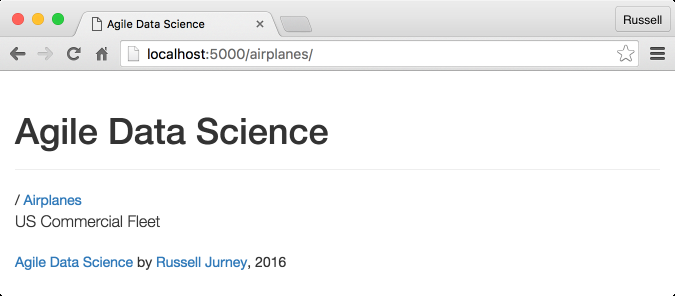

### Adding Search to the Airplanes Page

The `/airplanes` page is a great place to implement search for the airplane records we’ve created. To do this, first we’ll need to create a new search index and then index our airplane documents in Elasticsearch via PySpark:

In [61]:
%%bash

curl -XPUT 'http://localhost:9200/agile_data_science_airplanes/' -d '{
    "settings" : {
        "index" : {
            "number_of_shards" : 1,
            "number_of_replicas" : 1
        }
    }
}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (7) Failed to connect to localhost port 9200: Connection refused


In [57]:
# Load our airplanes
airplanes = spark.read.json("../data/airplanes.json")
airplanes.show(10)

airplanes.write.format("org.elasticsearch.spark.sql")\
  .option("es.resource","agile_data_science_airplanes/airplanes")\
  .mode("overwrite")\
  .save()

print("Records saved to Elasticsearch!")

+------------------+-----------+-----------------+----------------+--------------+--------------------+----------+------------+-------+
|EngineManufacturer|EngineModel|     Manufacturer|ManufacturerYear|         Model|               Owner|OwnerState|SerialNumber|TailNum|
+------------------+-----------+-----------------+----------------+--------------+--------------------+----------+------------+-------+
|        P&W CANADA|     PW206C|       AGUSTA SPA|            2001|         A109E|TRISTATE CARE FLI...|   ARIZONA|       11102| N365AA|
|             P & W|JT8D SERIES|MCDONNELL DOUGLAS|            1986|DC-9-82(MD-82)|AMERICAN AIRLINES...|     TEXAS|       49336| N424AA|
|             P & W|JT8D SERIES|MCDONNELL DOUGLAS|            1986|DC-9-82(MD-82)|AMERICAN AIRLINES...|     TEXAS|       49338| N426AA|
|             P & W|JT8D SERIES|MCDONNELL DOUGLAS|            1987|DC-9-83(MD-83)|AMERICAN AIRLINES...|     TEXAS|       49452| N434AA|
|             P & W|JT9D SERIES|MCDONNELL DOUGLA

We can verify our documents are there with a quick search:

In [63]:
%%bash

curl -XGET 'http://localhost:9200/agile_data_science_airplanes/_search?q=*' | jq ''

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (7) Failed to connect to localhost port 9200: Connection refused


Now we can add search capability to our `/airplanes` controller. Recall that we we did this in Chapter 5 for flight search, and that it took several pages of code. This time, we are going to build a reusable component for searching and displaying records in a Flask application.

### Code Versus Configuration

There are varying opinions on how much code duplication is acceptable before factoring it out, and this varies greatly by context and across programming disciplines. Data science has a higher tolerance for ugly, duplicated code than does general software engineering. This is for the simple reason that most code a data scientist writes is discarded immediately after it is run. Most data scientists are doing well to commit all their code to a repository at all (an absolute must!). But when code persists and we share the result, as in our application, cleanliness starts to matter.

This is the second time we’ve been tasked with implementing search, and when repeating oneself at length, it is a good time to take pause and see if one can’t reduce some of the redundant code necessary to reproduce a feature. (Because most code is throwaway in data science, it is important to wait until you repeat yourself to factor out duplicate code and generalize capabilities, as we have done here.)

Being tasked with generalizing code, we have to split our code into two elements: algorithms and configuration. Algorithms define the behavior of what we’re building; configuration defines what an instance of that algorithm is like.

To take one extreme, it is possible in programming to remove all redundancy in code, to the point that everything becomes a configuration file or an algorithm implementing the behavior of a configuration. This extreme, however, is not maintainable and isn’t compatible with a data scientist’s workload, where we have to remember lots of things at once and can’t dive deep into each component just to edit or make use of it. As usual in Agile Data Science, we choose the middle path, where we remove the worst of the redundancy without reducing everything to its most generalized, reusable form.

### Configuring a Search Widget

Our search configuration is simple. It lays out the fields we will search and display, and an optional label we would like to use in the user interface:

```python
  search_config = [
    {'field': 'TailNum', 'label': 'Tail Number'},
    {'field': 'Owner', 'sort_order': 0},
    {'field': 'OwnerState', 'label': 'Owner State'},
    {'field': 'Manufacturer', 'sort_order': 1},
    {'field': 'Model', 'sort_order': 2},
    {'field': 'ManufacturerYear', 'label': 'MFR Year'},
    {'field': 'SerialNumber', 'label': 'Serial Number'},
    {'field': 'EngineManufacturer', 'label': 'Engine MFR', 'sort_order': 3},
    {'field': 'EngineModel', 'label': 'Engine Model', 'sort_order': 4}
  ]
```

Our pagination works as before, but we’ve got a new configuration item for `AIRPLANE_RECORDS_PER_PAGE`:

```python
  # Pagination parameters
  start = request.args.get('start') or 0
  start = int(start)
  end = request.args.get('end') or config.AIRPLANE_RECORDS_PER_PAGE
  end = int(end)

  # Navigation path and offset setup
  nav_path = search_helpers.strip_place(request.url)
  nav_offsets = search_helpers.get_navigation_offsets(
    start, 
    end, 
    config.AIRPLANE_RECORDS_PER_PAGE
  )
```


With our search config in hand, we need only define the base of the Elasticsearch query and flesh it out based on the search arguments we receive. Our base query looks like this:

```python
  # Build the base of our elasticsearch query
  query = {
    'query': {
      'bool': {
        'must': []}
    },
    'sort': [
      {'Owner': {'order': 'asc'} },
      '_score'
    ],
    'from': start,
    'size': config.AIRPLANE_RECORDS_PER_PAGE
  }
```

And we parameterize it like so:

```python
  arg_dict = {}
  for item in search_config:
    field = item['field']
    value = request.args.get(field)
    print(field, value)
    arg_dict[field] = value
    if value:
      query['query']['bool']['must'].append({'match': {field: value}})
```

We submit the query as before:

```python
  # Query elasticsearch, process to get records and count
  results = elastic.search(query)
  airplanes, airplane_count = search_helpers.process_search(results)
```

In our call to render our template, we now include the search_config and arg_dict, which will generate our content in the template:

```python
  # Persist search parameters in the form template
  return render_template(
    'all_airplanes.html',
    search_config=search_config,
    args=arg_dict,
    airplanes=airplanes,
    airplane_count=airplane_count,
    nav_path=nav_path,
    nav_offsets=nav_offsets,
  )
```

Our template, `all_airplanes.html`, is derived from `search.html` from chapter 5. Using `search_config` and the request arguments, we programmatically build all the content we manually specified before in search.html. We can reuse this code now to re-create any search controller:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airplanes">Airplanes</a>

  <p class="lead" style="margin: 10px; margin-left: 0px;">
    <!-- Airline Name and website-->
    US Commercial Fleet
  </p>

  <!-- Chart of fleet manufacturers -->
  <div>
    <p style="margin: 0px;">Airplanes by Manufacturer</p>
    <div id="chart"><svg class="chart"></svg></div>
  </div>
  <script src="/static/airplanes.js"></script>

  <!-- Generate form from search_config and request args -->
  <form action="/airplanes" method="get">
    {% for item in search_config %}
      {% if 'label' in item %}
        <label for="{{item['field']}}">{{item['label']}}</label>
      {% else %}
        <label for="{{item['field']}}">{{item['field']}}</label>
      {% endif %}
        <input name="{{item['field']}}" style="width: 36px; margin-right: 10px;" value="{{args[item['field']] if args[item['field']] else ''}}"></input>
    {% endfor %}
    <button type="submit" class="btn btn-xs btn-default" style="height: 25px">Submit</button>
  </form>

  <table class="table table-condensed table-striped">
    <!-- Create table header, based on search_config -->
    <thead>
      {% for item in search_config %}
        {% if 'label' in item %}
          <th>{{item['label']}}</th>
        {% else %}
          <th>{{item['field']}}</th>
        {% endif %}
      {% endfor %}
    </thead>

    <!-- Create table content, based on airplanes for each <tr> and search_config for each <td> -->
    <tbody>
      {% for airplane in airplanes %}
      <tr>
        {% for item in search_config %}
          <td>{{airplane[item['field']]}}</td>
        {% endfor %}
      </tr>
      {% endfor %}
    </tbody>
  </table>

  <!-- css for x axis in chart -->
  <style>
    .axis text {
      font: 8px sans-serif;
    }

    .axis path,
    .axis line {
      fill: none;
      stroke: #000;
      shape-rendering: crispEdges;
    }

    .bar {
      fill: #ff6600;
    }
  </style>

{% import "macros.jnj" as common %}
{% if nav_offsets and nav_path -%}
  {{ common.display_nav(nav_offsets, nav_path, airplane_count)|safe }}
{% endif -%}
{% endblock %}
```

Check out the resulting search at [http://localhost:5000/airplanes](http://localhost:5000/airplanes)